In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

from matplotlib import animation
from IPython import display

import torch
import torch.nn as nn
import torch.optim as optim
from torch import Tensor
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
from torch.utils.data import DataLoader

In [2]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Down, self).__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    def __init__(self, in_channels, out_channels, bilinear=True):
        super(Up, self).__init__()

        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        else:
            self.up = nn.ConvTranspose2d(in_channels // 2, in_channels // 2, kernel_size=2, stride=2)

        self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)

        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = nn.functional.pad(x1, [diffX // 2, diffX - diffX // 2, diffY // 2, diffY - diffY // 2])
        
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        # Define your layers
        self.inc = DoubleConv(24, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        self.down4 = Down(512, 512)
        self.up1 = Up(1024, 256)
        self.up2 = Up(512, 128)
        self.up3 = Up(256, 64)
        self.up4 = Up(128, 64)
        self.outc = nn.Conv2d(64, 1, kernel_size=1)

    def forward(self, x):
        # Forward pass through the layers
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        x = self.outc(x)
        return x

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device
model = UNet()
model.load_state_dict(torch.load('/kaggle/input/tmptmptmp/model_checkpoint_e9.pt'))
model.eval()
model.to(device)

UNet(
  (inc): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(24, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (down1): Down(
    (maxpool_conv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): DoubleConv(
        (double_conv): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (4): BatchNorm2d(128, eps=1e-05, momen

In [4]:
# Same a the ContrailsAshDataset but does not load the mask (since its not avalble for test) and returns image_id instaed of the mask to assamble submission
class ContrailsAshTestDataset(torch.utils.data.Dataset):
    def __init__(self):
        self.df_idx: pd.DataFrame = pd.DataFrame({'idx': os.listdir(f'/kaggle/input/google-research-identify-contrails-reduce-global-warming/test')})
        self.parrent_folder: str = 'test'

    def __len__(self):
        return len(self.df_idx)

    def __getitem__(self, idx):
        image_id: int = int(self.df_idx.iloc[idx]['idx'])
        images = torch.tensor(np.reshape(get_ash_color_images(str(image_id), self.parrent_folder, get_mask_frame_only=False), (256, 256, 24))).to(torch.float32).permute(2, 0, 1)
        return images,  torch.tensor(image_id)

In [5]:
dataset_test = ContrailsAshTestDataset()
data_loader_test = DataLoader(dataset_test, batch_size=16, shuffle=True, num_workers=2)

In [6]:
#source https://www.kaggle.com/code/inversion/contrails-rle-submission?scriptVersionId=128527711&cellId=4

def rle_encode(x, fg_val=1):
    """
    Args:
        x:  numpy array of shape (height, width), 1 - mask, 0 - background
    Returns: run length encoding as list
    """

    dots = np.where(
        x.T.flatten() == fg_val)[0]  # .T sets Fortran order down-then-right
    run_lengths = []
    prev = -2
    for b in dots:
        if b > prev + 1:
            run_lengths.extend((b + 1, 0))
        run_lengths[-1] += 1
        prev = b
    return run_lengths


def list_to_string(x):
    """
    Converts list to a string representation
    Empty list returns '-'
    """
    if x: # non-empty list
        s = str(x).replace("[", "").replace("]", "").replace(",", "")
    else:
        s = '-'
    return s

In [7]:
submission = pd.read_csv('/kaggle/input/google-research-identify-contrails-reduce-global-warming/sample_submission.csv', index_col='record_id')

In [8]:
data_dir: str = '/kaggle/input/google-research-identify-contrails-reduce-global-warming'

In [9]:
def get_band_images(idx: str, parrent_folder: str, band: str) -> np.array:
    return np.load(os.path.join(data_dir, parrent_folder, idx, f'band_{band}.npy'))

_T11_BOUNDS = (243, 303)
_CLOUD_TOP_TDIFF_BOUNDS = (-4, 5)
_TDIFF_BOUNDS = (-4, 2)

def normalize_range(data, bounds):
    """Maps data to the range [0, 1]."""
    return (data - bounds[0]) / (bounds[1] - bounds[0])


def get_ash_color_images(idx: str, parrent_folder: str, get_mask_frame_only=False) -> np.array:
    band11 = get_band_images(idx, parrent_folder, '11')
    band14 = get_band_images(idx, parrent_folder, '14')
    band15 = get_band_images(idx, parrent_folder, '15')
    
    if get_mask_frame_only:
        band11 = band11[:,:,4]
        band14 = band14[:,:,4]
        band15 = band15[:,:,4]

    r = normalize_range(band15 - band14, _TDIFF_BOUNDS)
    g = normalize_range(band14 - band11, _CLOUD_TOP_TDIFF_BOUNDS)
    b = normalize_range(band14, _T11_BOUNDS)
    false_color = np.clip(np.stack([r, g, b], axis=2), 0, 1)
    return false_color

In [10]:
optim_threshold = 0.975

In [11]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

In [12]:
for i, data in enumerate(data_loader_test):
    break
    images, image_id = data
    
    # Predict mask for this instance
    if torch.cuda.is_available():
        images = images.cuda()
    predicated_mask = sigmoid(model.forward(images[:, :, :, :]).cpu().detach().numpy())
    
    # Apply threshold
    predicated_mask_with_threshold = np.zeros((images.shape[0], 256, 256))
    predicated_mask_with_threshold[predicated_mask[:, 0, :, :] < optim_threshold] = 0
    predicated_mask_with_threshold[predicated_mask[:, 0, :, :] > optim_threshold] = 1
    
    for img_num in range(0, images.shape[0]):
        current_mask = predicated_mask_with_threshold[img_num, :, :]
        current_image_id = image_id[0].item()
        
        plt.imshow(current_mask)
        plt.show()
        submission.loc[int(current_image_id), 'encoded_pixels'] = list_to_string(rle_encode(current_mask))

In [13]:
submission

,encoded_pixels
record_id,
1000834164244036115,1 3 10 5
1002653297254493116,-


In [14]:
dataset_test = ContrailsAshTestDataset()
data_loader_test = DataLoader(dataset_test, batch_size=1, shuffle=True, num_workers=2)

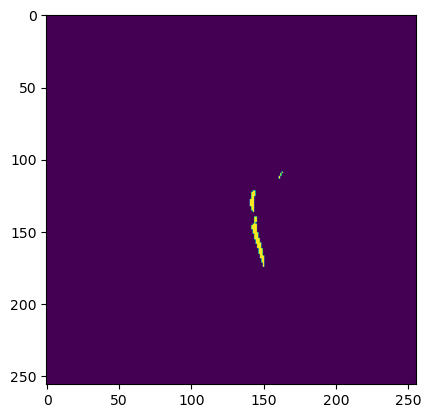

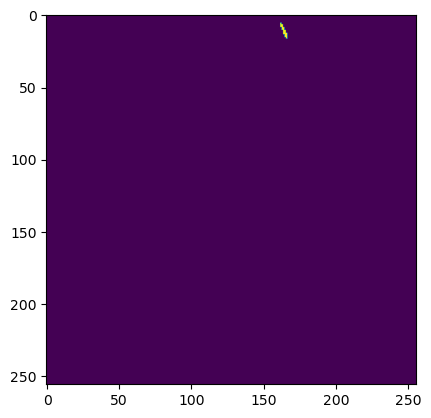

In [15]:
submission = pd.read_csv('/kaggle/input/google-research-identify-contrails-reduce-global-warming/sample_submission.csv', index_col='record_id')
model.eval()
with torch.no_grad():
    for X, rec in data_loader_test:
        X = X.to(device)
        pred = sigmoid(model.forward(X).cpu().detach().numpy())[0, 0, :, :]
        mask = np.zeros((256, 256))
        mask[pred<optim_threshold] = 0
        mask[pred>optim_threshold] = 1
        
        plt.imshow(mask)
        plt.show()
        submission.loc[int(rec[0]), 'encoded_pixels'] = list_to_string(rle_encode(mask))

In [16]:
submission

,encoded_pixels
record_id,
1000834164244036115,41479 3 41736 4 41994 5 42252 5 42510 4
1002653297254493116,36225 5 36476 13 36499 3 36731 15 36754 7 3698...


In [17]:
submission.to_csv('submission.csv')